In [775]:
import pandas as pd
import numpy as np
import os
import sys
import json
import requests
import gc
import re
from tqdm import tqdm
from datetime import datetime, timedelta
import datetime as dt
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
import pyarrow.parquet as pq

import statsmodels
import scipy.stats as ss
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from google.cloud import bigquery
from google.cloud.bigquery import job
import pandas as pd
import os
from tqdm import tqdm
import pandas as pd
PROJCECT = 'ballosodeuk'
bq = bigquery.Client(project=PROJCECT)

In [776]:
pd.get_option("display.max_columns")
pd.set_option("display.max_columns", 150)
pd.set_option("display.max_rows", 500)

In [777]:
query_name = "0608_행동데이터"
parquet_file = pq.ParquetFile(f"../result/{query_name}.parquet")
# print(parquet_file.schema)
df = pd.read_parquet(f"../result/{query_name}.parquet", engine='pyarrow')

- 유저아이디를 매우 많이 쓰는 유저가 블랙 유저일까? 추후 확인 필요. 지금은 매우 시간없음
- 일일로는 유저아이디 공백이 뚜렸했는데, 한달로 집계하니 유저아이디 공백이 없음. 개굳쓰

In [778]:
df['User_Id_cnt'] = df['User_Id'].apply(lambda x : len(x))


In [779]:
print("유저ID 2개 이상인 유저 : ", len(df[df['User_Id_cnt']>1]))
print(df['User_Id_cnt'].value_counts())


유저ID 2개 이상인 유저 :  1708
User_Id_cnt
1      590851
2        1516
3         133
4          19
5           9
7           3
6           3
8           2
16          2
10          2
9           2
43          1
11          1
17          1
15          1
19          1
89          1
53          1
14          1
110         1
101         1
77          1
12          1
18          1
47          1
71          1
20          1
61          1
Name: count, dtype: int64


In [780]:
df.drop(['adPopcorn_offerwall_reward','avati_offerwall_reward','rsp_reward','First_Cur_Cash','Last_Cur_Cash','Cum_Cash'],axis=1, inplace=True)
df.drop(['Joined_Date'],axis=1, inplace=True)
df.drop(['is_EasyLogin','is_CashLauncher','is_PushAgreed'],axis=1, inplace=True)


In [781]:
df.columns

Index(['Airbridge_Device_ID', 'User_Id', 'Platform', 'Sub_Division', 'Channel',
       'Campaign', 'tap_go__bf_list', 'bf_offerwall', 'coin_reward',
       'cp_reward_bf', 'chg_reward', 'chg_reward_cnt', 'chg_join',
       'cps_reward', 'bongtu_reward', 'invite_reward', 'cp_reward_homeCash',
       'spend', 'spend_cnt', 'avg_visit_interval', 'total_visits',
       'adClick_homeChg_ownedBanner', 'adClick_homeChg_adPopcorn',
       'adClick_homeChg_adPie', 'adClick_homeChg_mobion',
       'adClick_homeCash_coupang', 'adClick_homeCash_adPopcorn',
       'adClick_homeCash_adPie', 'adClick_home_adPopcorn',
       'adClick_homeBottom_owned', 'adClick_homeBottom_adPopcorn',
       'adClick_homeBottom_adPie', 'adClick_benefit_adPopcorn',
       'adClick_purchase_owned', 'adClick_chgList_adPopcorn',
       'adClick_chgList_adPie', 'adClick_chg_owned', 'adClick_chg_adPopcorn',
       'adClick_info_adPopcorn', 'adClick_exit_adPie',
       'adClick_benefit_bongtu_adPopcorn', 'adClick_benefit_butto

In [782]:
df.describe()

,tap_go__bf_list,bf_offerwall,coin_reward,cp_reward_bf,chg_reward,chg_reward_cnt,chg_join,cps_reward,bongtu_reward,invite_reward,cp_reward_homeCash,spend,spend_cnt,avg_visit_interval,total_visits,adClick_homeChg_ownedBanner,adClick_homeChg_adPopcorn,adClick_homeChg_adPie,adClick_homeChg_mobion,adClick_homeCash_coupang,adClick_homeCash_adPopcorn,adClick_homeCash_adPie,adClick_home_adPopcorn,adClick_homeBottom_owned,adClick_homeBottom_adPopcorn,adClick_homeBottom_adPie,adClick_benefit_adPopcorn,adClick_purchase_owned,adClick_chgList_adPopcorn,adClick_chgList_adPie,adClick_chg_owned,adClick_chg_adPopcorn,adClick_info_adPopcorn,adClick_exit_adPie,adClick_benefit_bongtu_adPopcorn,adClick_benefit_button_adPopcorn,adImp_homeChg_ownedBanner,adImp_homeChg_adPopcorn,adImp_homeChg_adPie,adImp_homeChg_mobion,adImp_homeCash_coupang,adImp_homeCash_adPopcorn,adImp_homeCash_adPie,adImp_home_adPopcorn,adImp_homeBottom_owned,adImp_homeBottom_adPopcorn,adImp_homeBottom_adPie,adImp_benefit_adPopcorn,adImp_purchase_owned,adImp_chgList_adPopcorn,adImp_chgList_adPie,adImp_chg_owned,adImp_chg_adPopcorn,adImp_info_adPopcorn,adImp_exit_adPie,adImp_benefit_bongtu_adPopcorn,adImp_benefit_button_adPopcorn,quiz_count,friend_get_link_count,friend_put_send_count,fund_receive_count,launcher,User_Id_cnt
count,592559.0,592559.0,592559.000000,592559.000000,5.925590e+05,592559.0,592559.0,592559.000000,5.925590e+05,5.925590e+05,592559.000000,5.925590e+05,592559.0,592559.000000,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.0,592559.000000
mean,9.033453,2.358673,252.039856,50.582136,1.045418e+03,7.813639,5.140727,21.164490,4.147084e+02,1.215547e+01,14.702165,9.131402e+02,0.12523,1.794917,15.275932,0.131082,0.060175,0.258692,1.182822,5.056977,0.205659,1.523847,0.055505,0.004631,0.017757,1.468915,0.019696,0.007083,0.003662,0.047783,0.000056,0.005716,0.000849,1.021196,0.007938,0.018672,87.765288,28.688736,59.591985,18.907948,33.352017,1.557539,10.003183,104.33207,0.91315,8.205218,20.155048,5.469602,15.930019,15.698094,21.285018,0.000413,39.109525,2.986425,6.156425,5.31002,13.928632,1.887532,0.183231,0.015551,0.013902,20.002383,1.004636
std,28.396747,27.238105,292.494629,97.695850,7.690626e+03,12.263893,6.632155,44.042483,7.368847e+03,1.349845e+03,20.640270,5.768628e+03,0.517002,2.499984,11.599359,0.740207,0.435594,2.191768,36.278668,8.855994,1.51067,6.817998,1.069592,0.230458,0.210864,22.920085,0.446083,0.117717,0.298398,0.576074,0.042869,0.22222,0.124485,16.72268,0.214063,0.177129,149.762083,63.677084,84.981773,62.8996,50.509249,5.815683,17.758393,170.564196,13.642121,30.227095,49.632154,23.993853,62.641122,39.042787,40.178016,0.23137,73.979069,21.59895,28.665147,56.402008,28.921956,17.308782,1.103192,0.187921,0.35853,71.200143,0.306517
min,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
25%,0.0,0.0,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,1.000000,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,6.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
50%,0.0,0.0,116.000000,0.000000,0.000000e+00,0.0,1.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,1.070000,15.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,4.0,29.0,2

In [783]:
len(df)

592559

## 접속 지역 피쳐 
---
해외출시이력이 없으므로, 접속지역이 해외라면, VPN 접속 가능성이 크다. \
VPN 유저는 광고를 클릭하지 않을 가능성이 크다.

해외 유저는 약 1.4%

In [784]:
prov = df.groupby('Sub_Division').agg({'Airbridge_Device_ID':'count'}).sort_values(by='Airbridge_Device_ID', ascending=False)
prov_ct = prov.rank(method='dense')['Airbridge_Device_ID'].apply(lambda x : 1 if x > 55 else 0)
prov_rst = prov.merge(prov_ct,left_index=True, right_index=True, how='left')
prov_rst.columns = ['prv_id', 'prv_ct']
prov_rst.loc['Tokyo','prv_ct'] = 0 # 제주도 랭킹 낮으므로 수기 변환
prov_rst.loc['Ōsaka','prv_ct'] = 0 # 제주도 랭킹 낮으므로 수기 변환

prov_grp = prov_rst.groupby('prv_ct').agg({'prv_id':'sum'})

print("해외 접속유저 : ", np.round(prov_grp.values[0]/prov_grp.values[1],2))


해외 접속유저 :  [0.01]


In [785]:
# 국내외 지역의 카테고리화
prov_rank = prov_rst[['prv_id']].rank(ascending=False).rename(columns={'prv_id':'prv_rank'}) 
prov_rst = prov_rst.merge(prov_rank,how='left',left_index=True,right_index=True )
prov_rst['prv_rank'] = prov_rst.apply(lambda row: 0 if row['prv_ct'] == 0 else row['prv_rank'], axis=1)

prov_rst.reset_index(inplace=True)

In [786]:
norm_df_len = len(df)
print(norm_df_len) # 본 세트에 병합

df = df.merge(prov_rst, on='Sub_Division', how='left')

if norm_df_len == len(df):
    df.drop(['Sub_Division'],axis=1,inplace=True)
    print(len(df))
    print("병합 완료, 이상 없음")
    print(f"Null 값 : {len(df.query('prv_ct.isna()'))}")

592559
592559
병합 완료, 이상 없음
Null 값 : 13280


In [787]:
print("지역 카테고리 지도")
prov_rst.query("prv_ct > 0")

지역 카테고리 지도


,Sub_Division,prv_id,prv_ct,prv_rank
0,Seoul,460932,1,1.0
1,Gyeonggi-do,24446,1,2.0
2,Ulsan,21829,1,3.0
3,Gyeongsangnam-do,9342,1,4.0
4,Busan,7477,1,5.0
5,Sejong-si,5793,1,6.0
6,Incheon,5719,1,7.0
7,Daegu,5405,1,8.0
8,Gyeongsangbuk-do,4699,1,9.0
9,Jeollabuk-do,4236,1,10.0


## 광고 통합
---

In [788]:
df.columns

Index(['Airbridge_Device_ID', 'User_Id', 'Platform', 'Channel', 'Campaign',
       'tap_go__bf_list', 'bf_offerwall', 'coin_reward', 'cp_reward_bf',
       'chg_reward', 'chg_reward_cnt', 'chg_join', 'cps_reward',
       'bongtu_reward', 'invite_reward', 'cp_reward_homeCash', 'spend',
       'spend_cnt', 'avg_visit_interval', 'total_visits',
       'adClick_homeChg_ownedBanner', 'adClick_homeChg_adPopcorn',
       'adClick_homeChg_adPie', 'adClick_homeChg_mobion',
       'adClick_homeCash_coupang', 'adClick_homeCash_adPopcorn',
       'adClick_homeCash_adPie', 'adClick_home_adPopcorn',
       'adClick_homeBottom_owned', 'adClick_homeBottom_adPopcorn',
       'adClick_homeBottom_adPie', 'adClick_benefit_adPopcorn',
       'adClick_purchase_owned', 'adClick_chgList_adPopcorn',
       'adClick_chgList_adPie', 'adClick_chg_owned', 'adClick_chg_adPopcorn',
       'adClick_info_adPopcorn', 'adClick_exit_adPie',
       'adClick_benefit_bongtu_adPopcorn', 'adClick_benefit_button_adPopcorn',
  

In [789]:
#Y값 위치 조회
loc_adClick_starts = df.columns.get_loc('adClick_homeChg_ownedBanner')
loc_adClick_ends = df.columns.get_loc('adClick_benefit_button_adPopcorn')
loc_adImp_starts = df.columns.get_loc('adImp_homeChg_ownedBanner')
loc_adImp_ends = df.columns.get_loc('adImp_benefit_button_adPopcorn')

print(loc_adClick_starts)
print(loc_adClick_ends)
print(loc_adImp_starts)
print(loc_adImp_ends)

20
40
41
61


In [790]:
ad_cols = df.iloc[:,loc_adClick_starts:loc_adImp_ends+1].columns
adClick_cols = df.iloc[:,loc_adClick_starts:loc_adClick_ends+1].columns
adImp_cols = df.iloc[:,loc_adImp_starts:loc_adImp_ends+1].columns

adClick_df = pd.concat([df[['Airbridge_Device_ID']],df[adClick_cols]], axis=1) # 광고 df 생성 
adImp_df = pd.concat([df[['Airbridge_Device_ID']],df[adImp_cols]], axis=1) # 광고 df 생성 

df.drop(ad_cols,axis=1,inplace=True) # df 내 광고 열 전체 drop

### 추적 가능 매출 기여 매체로 통폐합
- 개재 위치 & 광고 매체 경우의 수는 20개 가량
- 많은 경우의 수 대비 데이터의 Sparse함은 너무 방대함.
- 따라서 아래의 룰로 광고를 묶는다.
    - 광고는 배너 CPC광고, CPS 광고로 나눈다.
    - 지면은 홈캐시와 홈캐시 외 지면으로 나눈다.
        - 홈캐시 지면 : 홈캐시-cps, 홈캐시-네트워크, 
        - 홈캐시외 지면 : non-홈캐시-cps, non-홈캐시-네트워크

** 트래킹에서 bongtu_adpopcorn의 노출은 제외했음. 따라서 Imp가 Click 대비 열 하나가 작다.

In [791]:
adClick_df.set_index('Airbridge_Device_ID',inplace=True)

In [792]:
ad_list = adClick_df.columns.tolist()
print("총 열 갯수 : ",len(ad_list))

home_cash = list(filter(lambda x : 'homeCash' in x, ad_list))
non_home_cash = list(filter(lambda x : 'homeCash' not in x, ad_list))

cps_home_cash = list(filter(lambda x : 'coupang' in x, home_cash))
cpc_home_cash = list(filter(lambda x : 'coupang' not in x, home_cash))

cps_non_home_cash = list(filter(lambda x : 'coupang' in x, non_home_cash)) #view_get__reward로 봐야함.
cpc_non_home_cash = list(filter(lambda x : 'coupang' not in x, non_home_cash))

print("정리할 총 열 갯수 : ", len(cps_home_cash) + len(cpc_home_cash) + len(cpc_non_home_cash))

총 열 갯수 :  21
정리할 총 열 갯수 :  21


In [793]:
adClick_df['click_cps_home_cash'] = adClick_df[cps_home_cash].sum(axis=1)
adClick_df['click_cpc_home_cash'] = adClick_df[cpc_home_cash].sum(axis=1)
adClick_df['click_cpc_non_home_cash'] = adClick_df[cpc_non_home_cash].sum(axis=1)

In [794]:
adImp_df.set_index('Airbridge_Device_ID',inplace=True)

In [795]:
ad_list = adImp_df.columns.tolist()
print("총 열 갯수 : ",len(ad_list))

home_cash = list(filter(lambda x : 'homeCash' in x, ad_list))
non_home_cash = list(filter(lambda x : 'homeCash' not in x, ad_list))

cps_home_cash = list(filter(lambda x : 'coupang' in x, home_cash))
cpc_home_cash = list(filter(lambda x : 'coupang' not in x, home_cash))

cps_non_home_cash = list(filter(lambda x : 'coupang' in x, non_home_cash)) #view_get__reward로 봐야함.
cpc_non_home_cash = list(filter(lambda x : 'coupang' not in x, non_home_cash))

print("정리할 총 열 갯수 : ", len(cps_home_cash) + len(cpc_home_cash) + len(cpc_non_home_cash))

총 열 갯수 :  21
정리할 총 열 갯수 :  21


In [796]:
adImp_df['imp_cps_home_cash'] = adImp_df[cps_home_cash].sum(axis=1)
adImp_df['imp_cpc_home_cash'] = adImp_df[cpc_home_cash].sum(axis=1)
adImp_df['imp_cpc_non_home_cash'] = adImp_df[cpc_non_home_cash].sum(axis=1)

In [797]:
# 열 통폐합
adClick_df = adClick_df.iloc[:,-3:]
adImp_df = adImp_df.iloc[:,-3:]
# merge 준비
adClick_df.reset_index(inplace=True)
adImp_df.reset_index(inplace=True)

### 홈캐시 외 쿠팡 정리

In [798]:
df.columns

Index(['Airbridge_Device_ID', 'User_Id', 'Platform', 'Channel', 'Campaign',
       'tap_go__bf_list', 'bf_offerwall', 'coin_reward', 'cp_reward_bf',
       'chg_reward', 'chg_reward_cnt', 'chg_join', 'cps_reward',
       'bongtu_reward', 'invite_reward', 'cp_reward_homeCash', 'spend',
       'spend_cnt', 'avg_visit_interval', 'total_visits', 'quiz_count',
       'friend_get_link_count', 'friend_put_send_count', 'fund_receive_count',
       'launcher', 'User_Id_cnt', 'prv_id', 'prv_ct', 'prv_rank'],
      dtype='object')

## 외부 데이터셋 병합
---
1. 쿠팡 다이나믹
2. 쿠팡 혜택
3. 애드파이 (비율로 퉁)

### 쿠팡 홈코인

In [842]:
cp_homecoin = pd.read_csv('../result/20240401_20240531_cp_merged_Report.csv')

In [843]:
cp_homecoin.columns

Index(['Unnamed: 0', 'orderDate', 'trackingCode', 'subId', 'subParam',
       'addtag', 'ctag', 'orderId', 'productId', 'productName', 'quantity',
       'gmv', 'commissionRate', 'commission', 'date', 'refund_quantity',
       'refund_gmv', 'refund_commission', 'total_gmv', 'total_commission',
       'total_quantity'],
      dtype='object')

In [844]:

cp_homecoin.total_commission.sum()
# 6/10 기준, 쿠팡다이나믹 매출 ₩56,137,378

56174950.0

In [845]:
print('Uid 유실로 인한 매출 유실율' , cp_homecoin[(cp_homecoin['subParam'].notna()) ]['total_commission'].sum() / cp_homecoin.total_commission.sum() )
print(cp_homecoin.total_commission.sum() - cp_homecoin[(cp_homecoin['subParam'].notna()) ]['total_commission'].sum())
print("4/1 ~ 4/3, 유저아이디 미수집 & 수집 시작 기간, 리포트상 매출 8,146,474")

Uid 유실로 인한 매출 유실율 0.8675634246225409
7439618.0
4/1 ~ 4/3, 유저아이디 미수집 & 수집 시작 기간, 리포트상 매출 8,146,474


In [846]:
tt = cp_homecoin.groupby('orderDate').agg({'subParam':['count','size']})
tt = tt.reset_index()
tt

orderDate subParam      
                count  size
0   20240401        0  3755
1   20240402        1  3399
2   20240403     1549  3347
3   20240404     2969  3247
4   20240405     2636  2720
5   20240406     2646  2725
6   20240407     2685  2738
7   20240408     2868  2904
8   20240409     2676  2713
9   20240410     2936  2984
10  20240411     3205  3241
11  20240412     2910  2930
12  20240413     2835  2863
13  20240414     2729  2776
14  20240415     2885  2909
15  20240416     3107  3127
16  20240417     3142  3160
17  20240418     2385  2405
18  20240419     1789  1820
19  20240420     1566  1599
20  20240421     1323  1358
21  20240422     1734  1747
22  20240423     1839  1855
23  20240424     1979  1994
24  20240425     1615  1627
25  20240426     1497  1513
26  20240427     1617  1625
27  20240428     1555  1567
28  20240429     1667  1674
29  20240430     1603  1620

In [847]:
cp_homecoin = cp_homecoin[['subParam','orderDate','total_commission']]
cp_homecoin['orderDate'] = pd.to_datetime(cp_homecoin['orderDate'], errors='coerce')
cp_homecoin = cp_homecoin[(cp_homecoin['subParam'].notna()) & (cp_homecoin['orderDate'] < "2024-05-01") ]
cp_homecoin['subParam'] = cp_homecoin['subParam'].str.split('_').str[0]

cp_homecoin.total_commission.sum()

48735332.0

In [849]:
# 'User_Id' 열을 개별 행으로 확장
df_exploded = df.explode('User_Id')

# cp_homecoin 데이터프레임과 조인
merged_df = df_exploded.merge(cp_homecoin, left_on='User_Id', right_on='subParam', how='left')

# 각 Airbridge_Device_ID와 User_Id별로 고유한 total_commission 값을 가져옵니다.
unique_commissions = merged_df.drop_duplicates(subset=['Airbridge_Device_ID', 'User_Id', 'total_commission'])

# 각 Airbridge_Device_ID별로 total_commission 값을 합산
cp1_commission = unique_commissions.groupby('Airbridge_Device_ID').agg({'total_commission': 'sum'}).reset_index()
cp1_commission.rename(columns={'total_commission': 'cp_homecoin_rev'},inplace=True)


print("다수의 디바이스, 유저 아이디의 경우의 수 섞임. 최대한 중복 제거 시, 매출")
print(cp1_commission['cp_homecoin_rev'].sum(), cp_homecoin['total_commission'].sum())




다수의 디바이스, 유저 아이디의 경우의 수 섞임. 최대한 중복 제거 시, 매출
49915713.0 48735332.0


### 데이터셋 통합

In [850]:
df.drop(['User_Id_cnt','prv_id','Channel','Campaign'],axis=1,inplace=True)
df

,Airbridge_Device_ID,User_Id,Platform,tap_go__bf_list,bf_offerwall,coin_reward,cp_reward_bf,chg_reward,chg_reward_cnt,chg_join,cps_reward,bongtu_reward,invite_reward,cp_reward_homeCash,spend,spend_cnt,avg_visit_interval,total_visits,quiz_count,friend_get_link_count,friend_put_send_count,fund_receive_count,launcher,prv_ct,prv_rank
0,4db53fe9-a74e-4971-9cac-51768ddb35d1,[ba73cdfa-53b8-4060-b9c9-40754fd52886],Android,26,0,541.0,220.0,0.0,0,0,106.0,0.0,0.0,40.0,0.0,0,1.04,24,0,0,0,0,15,1.0,1.0
1,50cd7b62-3341-4fcc-b654-63ea37ba9ea5,[535187a2-113a-45b6-86d8-cd6b7ad98c2e],Android,36,0,897.0,300.0,4575.0,15,15,150.0,0.0,0.0,50.0,0.0,0,1.00,30,0,0,0,0,0,1.0,1.0
2,53312ebc-7e71-433e-b5b5-cc4f2b830c91,[1b91d913-3d58-4712-8e53-edce7728169d],Android,35,1,534.0,210.0,0.0,0,0,96.0,38.0,0.0,0.0,0.0,0,1.26,24,1,0,0,0,0,1.0,1.0
3,539ED233-A302-4B6B-A3D8-241C3321344B,[5a5a4430-921d-42b9-9415-f1416ef4faa7],iOS,0,1,3.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.00,1,0,0,0,0,0,1.0,7.0
4,54c606ee-490c-4c6b-ad4a-8323d6067415,[63d72b0f-f4c4-4515-953d-35d8f5591903],Android,0,0,93.0,0.0,0.0,0,0,0.0,0.0,0.0,20.0,0.0,0,2.17,13,0,0,0,0,12,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592554,2E45CE32-B9D5-4B8E-B69A-573BC414D301,[355b983c-b9e6-4a23-8c06-40a77b04d2a0],iOS,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.00,1,0,0,0,0,0,1.0,1.0
592555,d1223e4a-88a2-41be-8e4b-e614d793d94f,[608e29bd-c29e-4ee7-9c75-b6a89969d116],Android,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.00,1,0,0,0,0,0,1.0,1.0
592556,51098a31-7857-4e2d-b870-d1019bcb9a23,[9c3eafd3-5cbd-444b-bb4d-4f915e0eb3f2],Android,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.00,1,0,0,0,0,0,1.0,1.0
592557,525e0f1d-6367-4d9d-84d6-f129ed87cfa1,[b3f040f4-53c4-410d-95bf-227cc3d6e6cc],Android,1,1,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.00,1,0,0,0,0,0,1.0,1.0


In [851]:
df = df.merge(cp1_commission,on='Airbridge_Device_ID',how='left')
df = df.merge(adClick_df,on='Airbridge_Device_ID',how='left')
df = df.merge(adImp_df,on='Airbridge_Device_ID',how='left')


In [852]:
df.columns

Index(['Airbridge_Device_ID', 'User_Id', 'Platform', 'tap_go__bf_list',
       'bf_offerwall', 'coin_reward', 'cp_reward_bf', 'chg_reward',
       'chg_reward_cnt', 'chg_join', 'cps_reward', 'bongtu_reward',
       'invite_reward', 'cp_reward_homeCash', 'spend', 'spend_cnt',
       'avg_visit_interval', 'total_visits', 'quiz_count',
       'friend_get_link_count', 'friend_put_send_count', 'fund_receive_count',
       'launcher', 'prv_ct', 'prv_rank', 'cp_homecoin_rev',
       'click_cps_home_cash', 'click_cpc_home_cash', 'click_cpc_non_home_cash',
       'imp_cps_home_cash', 'imp_cpc_home_cash', 'imp_cpc_non_home_cash'],
      dtype='object')

## 피쳐 구간화
---

#### 전처리

In [856]:
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings(action='ignore')

In [857]:
df['cp_reward_bf_cnt'] = df['cp_reward_bf'] / 10

In [858]:
df.fillna(0,inplace=True)
target_vars = ['cp_homecoin_rev', 'click_cpc_home_cash', 'click_cpc_non_home_cash', 'bf_offerwall']

features = df.drop(columns=['Airbridge_Device_ID','User_Id'] + target_vars)
# features.set_index('Airbridge_Device_ID',inplace=True)
y1 = df['cp_homecoin_rev']
y2 = df['click_cpc_home_cash']
y3 = df['click_cpc_non_home_cash']
y4 = df['bf_offerwall']

lb = LabelEncoder()
platform = lb.fit_transform(features.Platform)

features['Platform'] = platform

In [859]:
tt_df = pd.concat([features,y1,y2,y3,y4],axis=1)
tt_df.set_index(df.Airbridge_Device_ID,inplace=True)

- 챌린지, 캐시버튼 적립이 0인 유저들은 매출 기여가 0이므로 제외한다.

In [860]:
tt_df = pd.concat([features,y1,y2,y3,y4],axis=1)
print(len(tt_df))
print(round(tt_df[(tt_df['chg_reward']==0) & (tt_df['coin_reward']==0)]['cp_homecoin_rev'].sum() / tt_df[(tt_df['chg_reward']!=0) & (tt_df['coin_reward']!=0)]['cp_homecoin_rev'].sum(),2))
print(round(tt_df[(tt_df['chg_reward']==0) & (tt_df['coin_reward']==0)]['click_cpc_home_cash'].sum() / tt_df[(tt_df['chg_reward']!=0) & (tt_df['coin_reward']!=0)]['click_cpc_home_cash'].sum(),2))
print(round(tt_df[(tt_df['chg_reward']==0) & (tt_df['coin_reward']==0)]['click_cpc_non_home_cash'].sum() / tt_df[(tt_df['chg_reward']!=0) & (tt_df['coin_reward']!=0)]['click_cpc_non_home_cash'].sum(),2))
print(round(tt_df[(tt_df['chg_reward']==0) & (tt_df['coin_reward']==0)]['bf_offerwall'].sum() / tt_df[(tt_df['chg_reward']!=0) & (tt_df['coin_reward']!=0)]['bf_offerwall'].sum(),2))

print(len(tt_df[(tt_df['chg_reward']==0) & (tt_df['coin_reward']==0)]) / len(tt_df))
print(len(tt_df[(tt_df['chg_reward']==0) & (tt_df['coin_reward']==0)]))


592559
0.01
0.0
0.01
0.01
0.2404655063883934
142490


In [861]:
tt_df = tt_df[~((tt_df['chg_reward'] == 0) & (tt_df['coin_reward'] == 0))]


In [862]:
non_tg = ['Platform', 'prv_ct', 'prv_rank', 'avg_visit_interval']
log_transform_cols = list(set(tt_df.columns.tolist()) - set(non_tg))

for col in log_transform_cols:
    tt_df[col] = np.log1p(tt_df[col])  # log1p is used to avoid log(0) issues

In [863]:
tt_df

,Platform,tap_go__bf_list,coin_reward,cp_reward_bf,chg_reward,chg_reward_cnt,chg_join,cps_reward,bongtu_reward,invite_reward,cp_reward_homeCash,spend,spend_cnt,avg_visit_interval,total_visits,quiz_count,friend_get_link_count,friend_put_send_count,fund_receive_count,launcher,prv_ct,prv_rank,click_cps_home_cash,imp_cps_home_cash,imp_cpc_home_cash,imp_cpc_non_home_cash,cp_reward_bf_cnt,cp_homecoin_rev,click_cpc_home_cash,click_cpc_non_home_cash,bf_offerwall
0,0,3.295837,6.295266,5.398163,0.000000,0.0,0.0,4.672829,0.000000,0.0,3.713572,0.0,0.0,1.04,3.218876,0.0,0.0,0.0,0.0,2.772589,1.0,1.0,1.386294,4.394449,2.302585,6.383507,3.135494,0.0,0.0,0.693147,0.0
1,0,3.610918,6.800170,5.707110,8.428581,2.772589,2.772589,5.017280,0.000000,0.0,3.931826,0.0,0.0,1.00,3.433987,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.94591,4.990433,2.70805,7.143618,3.433987,0.0,0.0,0.693147,0.0
2,0,3.583519,6.282267,5.351858,0.000000,0.0,0.0,4.574711,3.663562,0.0,0.000000,0.0,0.0,1.26,3.218876,0.693147,0.0,0.0,0.0,0.0,1.0,1.0,1.791759,4.369448,2.564949,6.419995,3.091042,0.0,1.098612,0.693147,0.693147
3,1,0.0,1.386294,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00,0.693147,0.0,0.0,0.0,0.0,0.0,1.0,7.0,0.0,0.0,0.0,2.079442,0.000000,0.0,0.0,0.0,0.693147
4,0,0.0,4.543295,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,3.044522,0.0,0.0,2.17,2.639057,0.0,0.0,0.0,0.0,2.564949,1.0,2.0,0.0,2.772589,0.0,4.89784,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592536,1,0.0,2.484907,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00,0.693147,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.693147,1.098612,0.0,2.079442,0.000000,0.0,0.0,0.0,0.0
592544,1,0.0,3.218876,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00,0.693147,0.0,0.0,0.0,0.0,0.0,1.0,15.0,0.693147,1.386294,1.098612,1.609438,0.000000,0.0,0.0,0.0,0.0
592546,1,0.0,2.302585,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00,0.693147,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.693147,0.693147,0.0,1.386294,0.000000,0.0,0.0,0.0,0.0
592547,0,0.693147,1.945910,2.397895,5.170484,0.693147,0.693147,0.693147,0.000000,0.0,2.397895,0.0,0.0,0.00,0.693147,0.0,0.0,0.0,0.0,1.609438,1.0,10.0,0.0,0.693147,0.0,4.204693,0.693147,0.0,0.0,0.0,0.0


In [864]:
lb.classes_

array(['Android', 'iOS'], dtype=object)

---

- 주요 수입 콘텐츠 상관관계 확인

In [865]:
tt_df.corr()[['cp_homecoin_rev'	,'click_cpc_home_cash'	,'click_cpc_non_home_cash'	,'bf_offerwall','cp_reward_bf']]

,cp_homecoin_rev,click_cpc_home_cash,click_cpc_non_home_cash,bf_offerwall,cp_reward_bf
Platform,0.004058,0.171859,-0.082705,-0.055461,-0.002927
tap_go__bf_list,-0.026727,0.282123,0.551095,0.490263,0.860901
coin_reward,0.083707,0.392670,0.290839,0.153003,0.401032
cp_reward_bf,-0.015981,0.278880,0.502296,0.371837,1.000000
chg_reward,0.016986,0.242110,0.328328,0.241769,0.475626
chg_reward_cnt,0.017574,0.253156,0.342543,0.242874,0.501627
chg_join,0.018971,0.249449,0.352840,0.258155,0.495669
cps_reward,-0.026318,0.291928,0.520087,0.402838,0.889107
bongtu_reward,0.010021,0.031522,0.156352,0.208262,0.076621
invite_reward,-0.002450,-0.004498,0.017537,0.041355,0.008449



### 주요 수입원 콘텐츠로 군집화 실행
1. 캐시버튼 수입, 챌린지 보상 수령 횟수 (챌린지 보상액에 편차 너무 큼), 오퍼월 진입


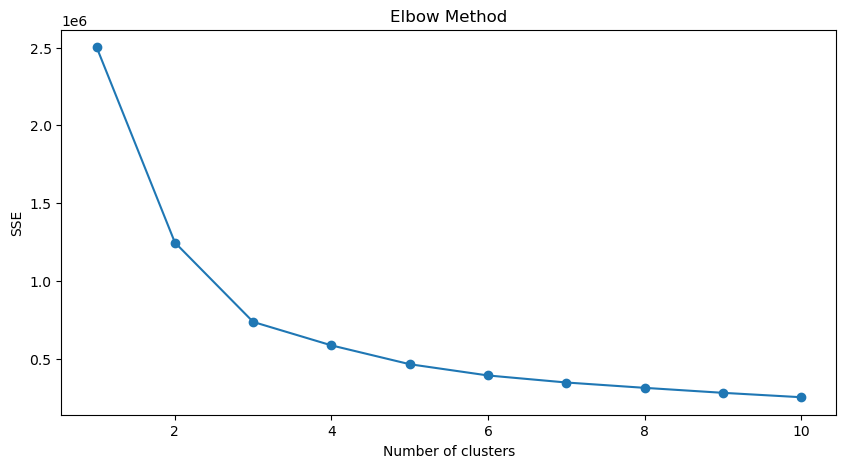

In [866]:
features = tt_df[['coin_reward', 'chg_reward_cnt', 'bf_offerwall']]

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(features)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

In [867]:
# 클러스터링을 위한 피쳐 선택
features = tt_df[['coin_reward', 'chg_reward_cnt', 'bf_offerwall']]

# 스케일링
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# 클러스터링 수행
kmeans = KMeans(n_clusters=4, random_state=0).fit(scaled_features)
tt_df['cluster'] = kmeans.labels_

# 각 클러스터의 크기 확인
print(tt_df['cluster'].value_counts())

cluster
0    174199
1    151072
2    102549
3     22249
Name: count, dtype: int64


In [868]:
df.columns

Index(['Airbridge_Device_ID', 'User_Id', 'Platform', 'tap_go__bf_list',
       'bf_offerwall', 'coin_reward', 'cp_reward_bf', 'chg_reward',
       'chg_reward_cnt', 'chg_join', 'cps_reward', 'bongtu_reward',
       'invite_reward', 'cp_reward_homeCash', 'spend', 'spend_cnt',
       'avg_visit_interval', 'total_visits', 'quiz_count',
       'friend_get_link_count', 'friend_put_send_count', 'fund_receive_count',
       'launcher', 'prv_ct', 'prv_rank', 'cp_homecoin_rev',
       'click_cps_home_cash', 'click_cpc_home_cash', 'click_cpc_non_home_cash',
       'imp_cps_home_cash', 'imp_cpc_home_cash', 'imp_cpc_non_home_cash',
       'cp_reward_bf_cnt'],
      dtype='object')

In [869]:
# 역로그 변환
tt_df['unLog_coin_reward'] = np.expm1(tt_df['coin_reward'])
tt_df['unLog_chg_reward_cnt'] = np.expm1(tt_df['chg_reward_cnt'])
tt_df['unLog_bf_offerwall'] = np.expm1(tt_df['bf_offerwall'])

tt_df['unLog_cp_homecoin_rev'] = np.expm1(tt_df['cp_homecoin_rev'])
tt_df['unLog_click_cpc_home_cash'] = np.expm1(tt_df['click_cpc_home_cash'])
tt_df['unLog_click_cpc_non_home_cash'] = np.expm1(tt_df['click_cpc_non_home_cash'])
tt_df['unLog_click_cps_home_cash'] = np.expm1(tt_df['click_cps_home_cash'])
tt_df['unLog_cp_reward_bf'] = np.expm1(tt_df['cp_reward_bf'])
tt_df['unLog_cp_reward_bf_cnt'] = np.expm1(tt_df['cp_reward_bf_cnt'])

tt_df['unLog_tap_go__bf_list'] = np.expm1(tt_df['tap_go__bf_list'])
tt_df['unLog_chg_reward'] = np.expm1(tt_df['chg_reward'])
tt_df['unLog_cps_reward'] = np.expm1(tt_df['cps_reward'])
tt_df['unLog_bongtu_reward'] = np.expm1(tt_df['bongtu_reward'])
tt_df['unLog_invite_reward'] = np.expm1(tt_df['invite_reward'])
tt_df['unLog_cp_reward_homeCash'] = np.expm1(tt_df['cp_reward_homeCash'])
tt_df['unLog_spend'] = np.expm1(tt_df['spend'])
tt_df['unLog_friend_get_link_count'] = np.expm1(tt_df['friend_get_link_count'])
tt_df['unLog_friend_put_send_count'] = np.expm1(tt_df['friend_put_send_count'])
tt_df['unLog_fund_receive_count'] = np.expm1(tt_df['fund_receive_count'])
tt_df['unLog_launcher'] = np.expm1(tt_df['launcher'])
tt_df['unLog_prv_ct'] = np.expm1(tt_df['prv_ct'])
tt_df['unLog_prv_rank'] = np.expm1(tt_df['prv_rank'])
tt_df['unLog_total_visits'] = np.expm1(tt_df['total_visits'])
tt_df['unLog_quiz_count'] = np.expm1(tt_df['quiz_count'])



In [870]:
### 평균
cohort_analysis = tt_df.groupby('cluster').agg(
    {
        'unLog_coin_reward':'mean', 'unLog_chg_reward_cnt':'mean', 'unLog_bf_offerwall':'mean',
        'unLog_cp_homecoin_rev':'mean','unLog_click_cpc_home_cash':'mean','unLog_click_cpc_non_home_cash':'mean','unLog_click_cps_home_cash':'mean',
        'unLog_cp_reward_bf':'mean','unLog_cp_reward_bf_cnt':'mean',
        'avg_visit_interval':'mean',
        'Platform':'count',

        'unLog_tap_go__bf_list' :'mean',
        'unLog_chg_reward' :'mean',
        'unLog_cps_reward' :'mean',
        'unLog_bongtu_reward' :'mean',
        'unLog_invite_reward' :'mean',
        'unLog_cp_reward_homeCash' :'mean',
        'unLog_spend' :'mean',
        'unLog_friend_get_link_count' :'mean',
        'unLog_friend_put_send_count' :'mean',
        'unLog_fund_receive_count' :'mean',
        'unLog_launcher' :'mean',
        'unLog_total_visits' :'mean',
        'unLog_quiz_count' :'mean'

     })

platform_counts = tt_df.groupby(['cluster', 'Platform']).size().unstack(fill_value=0) # os 수
platform_counts.columns = ['AOS','IOS']

cohort_analysis = cohort_analysis.merge(platform_counts,left_index=True,right_index=True,how='left')

In [871]:

cohort_analysis = tt_df.groupby('cluster').agg(
    {
        'unLog_coin_reward':'sum', 'unLog_chg_reward_cnt':'sum', 'unLog_bf_offerwall':'sum',
        'unLog_cp_homecoin_rev':'sum','unLog_click_cpc_home_cash':'sum','unLog_click_cpc_non_home_cash':'sum','unLog_click_cps_home_cash':'sum',
        'unLog_cp_reward_bf':'sum','unLog_cp_reward_bf_cnt':'sum',
        'avg_visit_interval':'mean',
        'Platform':'count',

        'unLog_tap_go__bf_list' :'sum',
        'unLog_chg_reward' :'sum',
        'unLog_cps_reward' :'sum',
        'unLog_bongtu_reward' :'sum',
        'unLog_invite_reward' :'sum',
        'unLog_cp_reward_homeCash' :'sum',
        'unLog_spend' :'sum',
        'unLog_friend_get_link_count' :'sum',
        'unLog_friend_put_send_count' :'sum',
        'unLog_fund_receive_count' :'sum',
        'unLog_launcher' :'sum',
        'unLog_total_visits' :'sum',
        'unLog_quiz_count' :'sum'

     })

platform_counts = tt_df.groupby(['cluster', 'Platform']).size().unstack(fill_value=0) # os 수
platform_counts.columns = ['AOS','IOS']

cohort_analysis = cohort_analysis.merge(platform_counts,left_index=True,right_index=True,how='left')

In [872]:
df.chg_reward.sum()

619471554.0

In [873]:
cohort_analysis.T

cluster,0,1,2,3
unLog_coin_reward,91165450.0,44150810.0,1807698.0,12224527.0
unLog_chg_reward_cnt,3923297.0,64779.0,146737.0,495183.0
unLog_bf_offerwall,85950.0,48959.0,33154.0,1214343.0
unLog_cp_homecoin_rev,22328841.0,22227573.0,3232564.0,1907199.0
unLog_click_cpc_home_cash,614274.0,271643.0,17036.0,121881.0
unLog_click_cpc_non_home_cash,1363050.0,291951.0,52173.0,829535.0
unLog_click_cps_home_cash,1734215.0,910546.0,80410.0,271382.0
unLog_cp_reward_bf,20698130.0,4086370.0,576960.0,4484950.0
unLog_cp_reward_bf_cnt,2069813.0,408637.0,57696.0,448495.0
avg_visit_interval,1.10531,1.772308,2.800475,1.074009


In [874]:
cohort_analysis = tt_df.groupby('cluster').agg(
    {
        'unLog_coin_reward':'sum', 'unLog_chg_reward_cnt':'sum', 'unLog_bf_offerwall':'sum',
        'unLog_cp_homecoin_rev':'sum','unLog_click_cpc_home_cash':'sum','unLog_click_cpc_non_home_cash':'sum','unLog_click_cps_home_cash':'sum',
        'avg_visit_interval':'sum',
        'Platform':'count'
     })
cohort_analysis['homecoin_arp'] = cohort_analysis['unLog_cp_homecoin_rev']/ cohort_analysis['Platform']
cohort_analysis

,unLog_coin_reward,unLog_chg_reward_cnt,unLog_bf_offerwall,unLog_cp_homecoin_rev,unLog_click_cpc_home_cash,unLog_click_cpc_non_home_cash,unLog_click_cps_home_cash,avg_visit_interval,Platform,homecoin_arp
cluster,,,,,,,,,,
0,91165450.0,3923297.0,85950.0,22328841.0,614274.0,1363050.0,1734215.0,192543.86,174199,128.180076
1,44150810.0,64779.0,48959.0,22227573.0,271643.0,291951.0,910546.0,267746.17,151072,147.132314
2,1807698.0,146737.0,33154.0,3232564.0,17036.0,52173.0,80410.0,287185.90,102549,31.522141
3,12224527.0,495183.0,1214343.0,1907199.0,121881.0,829535.0,271382.0,23895.63,22249,85.720662


In [875]:
cohort_analysis

,unLog_coin_reward,unLog_chg_reward_cnt,unLog_bf_offerwall,unLog_cp_homecoin_rev,unLog_click_cpc_home_cash,unLog_click_cpc_non_home_cash,unLog_click_cps_home_cash,avg_visit_interval,Platform,homecoin_arp
cluster,,,,,,,,,,
0,91165450.0,3923297.0,85950.0,22328841.0,614274.0,1363050.0,1734215.0,192543.86,174199,128.180076
1,44150810.0,64779.0,48959.0,22227573.0,271643.0,291951.0,910546.0,267746.17,151072,147.132314
2,1807698.0,146737.0,33154.0,3232564.0,17036.0,52173.0,80410.0,287185.90,102549,31.522141
3,12224527.0,495183.0,1214343.0,1907199.0,121881.0,829535.0,271382.0,23895.63,22249,85.720662


In [876]:
platform_counts

,AOS,IOS
cluster,,
0,140256,33943
1,131653,19419
2,79149,23400
3,19691,2558


In [877]:
tt_df.chg_reward.sum()

1866188.7247663033

#### 챌린지로만?

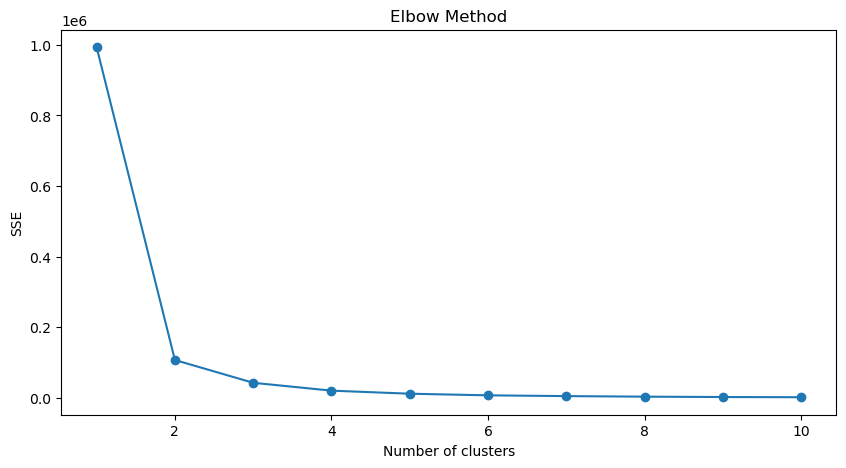

In [766]:
features = tt_df[['chg_reward_cnt']]

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(features)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

In [767]:
# 클러스터링을 위한 피쳐 선택


# 스케일링
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# 클러스터링 수행
kmeans = KMeans(n_clusters=2, random_state=0).fit(scaled_features)
tt_df['cluster'] = kmeans.labels_

# 각 클러스터의 크기 확인
print(tt_df['cluster'].value_counts())

cluster
1    243103
0    206966
Name: count, dtype: int64


In [768]:
# 역로그 변환
tt_df['unLog_coin_reward'] = np.expm1(tt_df['coin_reward'])
tt_df['unLog_chg_reward_cnt'] = np.expm1(tt_df['chg_reward_cnt'])
tt_df['unLog_bf_offerwall'] = np.expm1(tt_df['bf_offerwall'])

tt_df['unLog_cp_homecoin_rev'] = np.expm1(tt_df['cp_homecoin_rev'])
tt_df['unLog_click_cpc_home_cash'] = np.expm1(tt_df['click_cpc_home_cash'])
tt_df['unLog_click_cpc_non_home_cash'] = np.expm1(tt_df['click_cpc_non_home_cash'])
tt_df['unLog_click_cps_home_cash'] = np.expm1(tt_df['click_cps_home_cash'])
tt_df['unLog_cp_reward_bf'] = np.expm1(tt_df['cp_reward_bf'])
tt_df['unLog_cp_reward_bf_cnt'] = np.expm1(tt_df['cp_reward_bf_cnt'])

tt_df['unLog_tap_go__bf_list'] = np.expm1(tt_df['tap_go__bf_list'])
tt_df['unLog_chg_reward'] = np.expm1(tt_df['chg_reward'])
tt_df['unLog_cps_reward'] = np.expm1(tt_df['cps_reward'])
tt_df['unLog_bongtu_reward'] = np.expm1(tt_df['bongtu_reward'])
tt_df['unLog_invite_reward'] = np.expm1(tt_df['invite_reward'])
tt_df['unLog_cp_reward_homeCash'] = np.expm1(tt_df['cp_reward_homeCash'])
tt_df['unLog_spend'] = np.expm1(tt_df['spend'])
tt_df['unLog_friend_get_link_count'] = np.expm1(tt_df['friend_get_link_count'])
tt_df['unLog_friend_put_send_count'] = np.expm1(tt_df['friend_put_send_count'])
tt_df['unLog_fund_receive_count'] = np.expm1(tt_df['fund_receive_count'])
tt_df['unLog_launcher'] = np.expm1(tt_df['launcher'])
tt_df['unLog_prv_ct'] = np.expm1(tt_df['prv_ct'])
tt_df['unLog_prv_rank'] = np.expm1(tt_df['prv_rank'])
tt_df['unLog_total_visits'] = np.expm1(tt_df['total_visits'])
tt_df['unLog_quiz_count'] = np.expm1(tt_df['quiz_count'])


cohort_analysis = tt_df.groupby('cluster').agg(
    {
        'unLog_coin_reward':'mean', 'unLog_chg_reward_cnt':'mean', 'unLog_bf_offerwall':'mean',
        'unLog_cp_homecoin_rev':'mean','unLog_click_cpc_home_cash':'mean','unLog_click_cpc_non_home_cash':'mean','unLog_click_cps_home_cash':'mean',
        'unLog_cp_reward_bf':'mean','unLog_cp_reward_bf_cnt':'mean',
        'avg_visit_interval':'mean',
        'Platform':'count',

        'unLog_tap_go__bf_list' :'mean',
        'unLog_chg_reward' :'mean',
        'unLog_cps_reward' :'mean',
        'unLog_bongtu_reward' :'mean',
        'unLog_invite_reward' :'mean',
        'unLog_cp_reward_homeCash' :'mean',
        'unLog_spend' :'mean',
        'unLog_friend_get_link_count' :'mean',
        'unLog_friend_put_send_count' :'mean',
        'unLog_fund_receive_count' :'mean',
        'unLog_launcher' :'mean',
        'unLog_total_visits' :'mean',
        'unLog_quiz_count' :'mean'

     })

platform_counts = tt_df.groupby(['cluster', 'Platform']).size().unstack(fill_value=0) # os 수
platform_counts.columns = ['AOS','IOS']

cohort_analysis = cohort_analysis.merge(platform_counts,left_index=True,right_index=True,how='left')

In [770]:

cohort_analysis = tt_df.groupby('cluster').agg(
    {
        'unLog_coin_reward':'sum', 'unLog_chg_reward_cnt':'sum', 'unLog_bf_offerwall':'sum',
        'unLog_cp_homecoin_rev':'sum','unLog_click_cpc_home_cash':'sum','unLog_click_cpc_non_home_cash':'sum','unLog_click_cps_home_cash':'sum',
        'unLog_cp_reward_bf':'sum','unLog_cp_reward_bf_cnt':'sum',
        'avg_visit_interval':'mean',
        'Platform':'count',

        'unLog_tap_go__bf_list' :'sum',
        'unLog_chg_reward' :'sum',
        'unLog_cps_reward' :'sum',
        'unLog_bongtu_reward' :'sum',
        'unLog_invite_reward' :'sum',
        'unLog_cp_reward_homeCash' :'sum',
        'unLog_spend' :'sum',
        'unLog_friend_get_link_count' :'sum',
        'unLog_friend_put_send_count' :'sum',
        'unLog_fund_receive_count' :'sum',
        'unLog_launcher' :'sum',
        'unLog_total_visits' :'sum',
        'unLog_quiz_count' :'sum'

     })

platform_counts = tt_df.groupby(['cluster', 'Platform']).size().unstack(fill_value=0) # os 수
platform_counts.columns = ['AOS','IOS']

cohort_analysis = cohort_analysis.merge(platform_counts,left_index=True,right_index=True,how='left')

In [771]:
cohort_analysis.T

cluster,0,1
unLog_coin_reward,103108214.0,46240271.0
unLog_chg_reward_cnt,4552491.0,77505.0
unLog_bf_offerwall,1246879.0,135527.0
unLog_cp_homecoin_rev,24727538.0,24968639.0
unLog_click_cpc_home_cash,729371.0,295463.0
unLog_click_cpc_non_home_cash,2157672.0,379037.0
unLog_click_cps_home_cash,1998675.0,997878.0
unLog_cp_reward_bf,25188420.0,4657990.0
unLog_cp_reward_bf_cnt,2518842.0,465799.0
avg_visit_interval,1.135234,2.206541


#### y값으로 군집화

<Axes: ylabel='Density'>

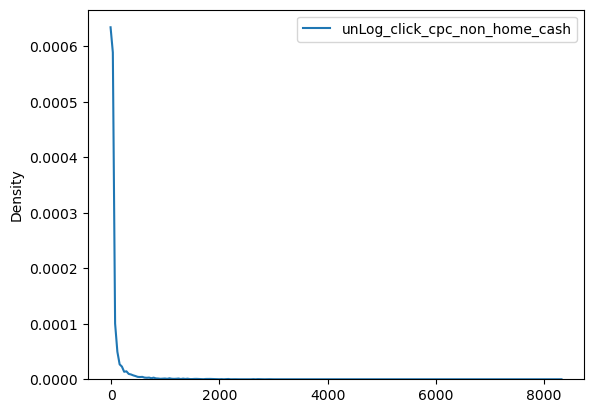

In [613]:
sns.kdeplot(features)

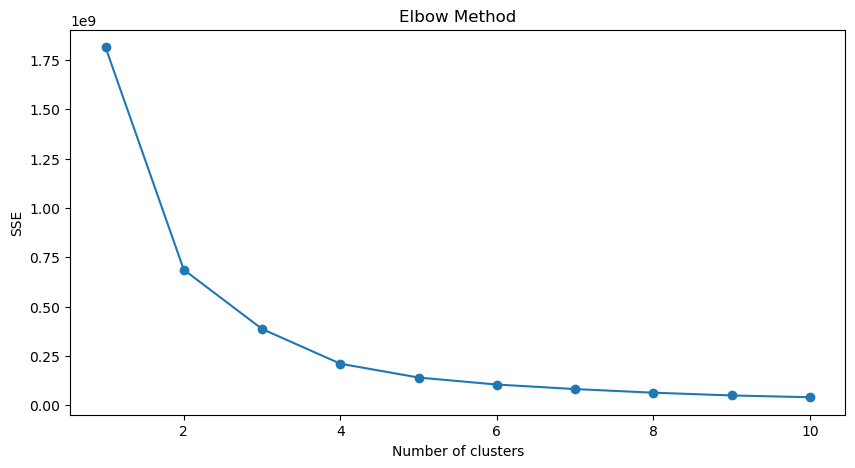

In [764]:
sse = []
features = tt_df[['unLog_click_cpc_non_home_cash']]
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(features)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

In [765]:
# 클러스터링을 위한 피쳐 선택

# 스케일링
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# 클러스터링 수행
kmeans = KMeans(n_clusters=4, random_state=0).fit(scaled_features)
tt_df['cluster'] = kmeans.labels_

# 각 클러스터의 크기 확인
print(tt_df['cluster'].value_counts())

cluster
0    448036
1      1605
2       391
3        37
Name: count, dtype: int64


In [552]:
# 역로그 변환
tt_df['unLog_coin_reward'] = np.expm1(tt_df['coin_reward'])
tt_df['unLog_chg_reward_cnt'] = np.expm1(tt_df['chg_reward_cnt'])
tt_df['unLog_bf_offerwall'] = np.expm1(tt_df['bf_offerwall'])

tt_df['unLog_cp_homecoin_rev'] = np.expm1(tt_df['cp_homecoin_rev'])
tt_df['unLog_click_cpc_home_cash'] = np.expm1(tt_df['click_cpc_home_cash'])
tt_df['unLog_click_cpc_non_home_cash'] = np.expm1(tt_df['click_cpc_non_home_cash'])
tt_df['unLog_click_cps_home_cash'] = np.expm1(tt_df['click_cps_home_cash'])

tt_df['unLog_tap_go__bf_list'] = np.expm1(tt_df['tap_go__bf_list'])
tt_df['unLog_chg_reward'] = np.expm1(tt_df['chg_reward'])
tt_df['unLog_cps_reward'] = np.expm1(tt_df['cps_reward'])
tt_df['unLog_bongtu_reward'] = np.expm1(tt_df['bongtu_reward'])
tt_df['unLog_invite_reward'] = np.expm1(tt_df['invite_reward'])
tt_df['unLog_cp_reward_homeCash'] = np.expm1(tt_df['cp_reward_homeCash'])
tt_df['unLog_spend'] = np.expm1(tt_df['spend'])
tt_df['unLog_friend_get_link_count'] = np.expm1(tt_df['friend_get_link_count'])
tt_df['unLog_friend_put_send_count'] = np.expm1(tt_df['friend_put_send_count'])
tt_df['unLog_fund_receive_count'] = np.expm1(tt_df['fund_receive_count'])
tt_df['unLog_launcher'] = np.expm1(tt_df['launcher'])
tt_df['unLog_prv_ct'] = np.expm1(tt_df['prv_ct'])
tt_df['unLog_prv_rank'] = np.expm1(tt_df['prv_rank'])
tt_df['unLog_total_visits'] = np.expm1(tt_df['total_visits'])
tt_df['unLog_quiz_count'] = np.expm1(tt_df['quiz_count'])



In [553]:

cohort_analysis = tt_df.groupby('cluster').agg(
    {
        'unLog_cp_homecoin_rev':'mean','unLog_click_cpc_home_cash':'mean','unLog_click_cpc_non_home_cash':'mean','unLog_click_cps_home_cash':'mean',
        'unLog_coin_reward':'mean', 'unLog_chg_reward_cnt':'mean', 'unLog_bf_offerwall':'mean',
        'avg_visit_interval':'mean',
        'Platform':'count',

        'unLog_tap_go__bf_list' :'mean',
        'unLog_chg_reward' :'mean',
        'unLog_cps_reward' :'mean',
        'unLog_bongtu_reward' :'mean',
        'unLog_invite_reward' :'mean',
        'unLog_cp_reward_homeCash' :'mean',
        'unLog_spend' :'mean',
        'unLog_friend_get_link_count' :'mean',
        'unLog_friend_put_send_count' :'mean',
        'unLog_fund_receive_count' :'mean',
        'unLog_launcher' :'mean',
        'unLog_total_visits' :'mean',
        'unLog_quiz_count' :'mean'

     })

platform_counts = tt_df.groupby(['cluster', 'Platform']).size().unstack(fill_value=0) # os 수
platform_counts.columns = ['AOS','IOS']
city_counts = tt_df.groupby(['cluster', 'prv_rank']).size().unstack(fill_value=0) # os 수

cohort_analysis = cohort_analysis.merge(platform_counts,left_index=True,right_index=True,how='left')

In [554]:
cohort_analysis.T

cluster,0,1,2,3
unLog_cp_homecoin_rev,110.694377,50.92648,42.069054,79.054054
unLog_click_cpc_home_cash,2.245744,8.900312,9.872123,13.918919
unLog_click_cpc_non_home_cash,2.594548,427.628037,1388.462916,3919.621622
unLog_click_cps_home_cash,6.619102,15.386293,14.557545,15.405405
unLog_coin_reward,330.15744,692.888474,726.716113,806.324324
unLog_chg_reward_cnt,10.217179,25.692212,25.70844,28.216216
unLog_bf_offerwall,2.836426,48.028037,67.086957,223.486486
avg_visit_interval,1.717063,1.018405,1.007136,1.0
Platform,448036,1605,391,37
unLog_tap_go__bf_list,11.410503,84.993146,116.414322,327.243243


#### 광고 지면 묶지 않기
- 아직 진행중

In [623]:
query_name = "0608_행동데이터"
parquet_file = pq.ParquetFile(f"../result/{query_name}.parquet")
# print(parquet_file.schema)
df = pd.read_parquet(f"../result/{query_name}.parquet", engine='pyarrow')

df.drop(['adPopcorn_offerwall_reward','avati_offerwall_reward','rsp_reward','First_Cur_Cash','Last_Cur_Cash','Cum_Cash'],axis=1, inplace=True)
df.drop(['Joined_Date'],axis=1, inplace=True)
df.drop(['is_EasyLogin','is_CashLauncher','is_PushAgreed'],axis=1, inplace=True)


In [630]:
df.fillna(0,inplace=True)

tt_df = df.copy()
tt_df = tt_df[(tt_df['chg_reward']!=0) | (tt_df['coin_reward']!=0)]
len(tt_df)

450069

In [634]:
non_tg = ['Platform', 'prv_ct', 'prv_rank', 'avg_visit_interval']
log_transform_cols = list(set(tt_df.columns.tolist()) - set(non_tg))

for col in log_transform_cols:
    tt_df[col] = np.log1p(tt_df[col])  # log1p is used to avoid log(0) issues

TypeError: loop of ufunc does not support argument 0 of type int which has no callable log1p method

cluster
0    117.784241
2    104.586216
1      1.734432
Name: cp_homecoin_rev, dtype: float64


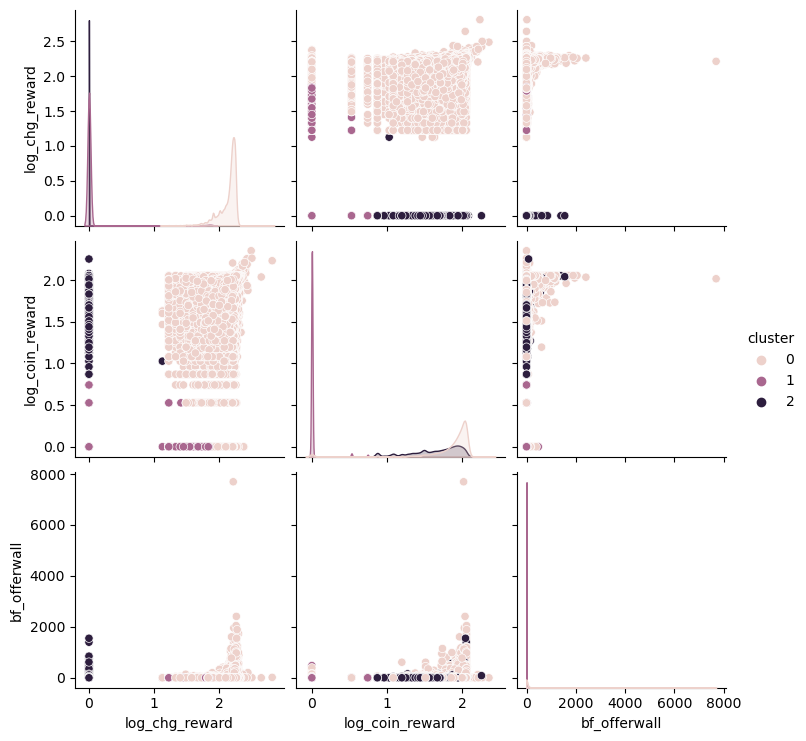

In [256]:
c_df = tt_df.copy()

# 0과 나머지 값을 분할
zero_df = c_df[(c_df['chg_reward'] == 0) & (c_df['coin_reward'] == 0)]
non_zero_df = c_df[(c_df['chg_reward'] != 0) | (c_df['coin_reward'] != 0)]

# 나머지 값에 대해 로그 변환
non_zero_df['log_chg_reward'] = np.log1p(non_zero_df['chg_reward'])
non_zero_df['log_coin_reward'] = np.log1p(non_zero_df['coin_reward'])

# 두 서브셋 결합 (로그 변환된 값으로)
combined_df = pd.concat([zero_df, non_zero_df], axis=0)

# 클러스터링을 위한 피쳐 선택 (로그 변환된 값 사용)
features = combined_df[['log_chg_reward', 'log_coin_reward']]

# NaN 값을 0으로 대체 (로그 변환 후 NaN이 생길 수 있으므로)
features = features.fillna(0)

# 클러스터링
kmeans = KMeans(n_clusters=3, random_state=0).fit(features)
combined_df['cluster'] = kmeans.labels_

# 클러스터별 매출 기여도 분석
cohort_analysis = combined_df.groupby('cluster')['cp_homecoin_rev'].mean().sort_values(ascending=False)
print(cohort_analysis)




In [257]:
combined_df

,Platform,tap_go__bf_list,coin_reward,cp_reward_bf,chg_reward,chg_reward_cnt,chg_join,cps_reward,bongtu_reward,invite_reward,cp_reward_homeCash,spend,spend_cnt,avg_visit_interval,total_visits,quiz_count,friend_get_link_count,friend_put_send_count,fund_receive_count,launcher,prv_ct,prv_rank,click_cps_home_cash,imp_cps_home_cash,imp_cpc_home_cash,imp_cpc_non_home_cash,cluster,cp_homecoin_rev,click_cpc_home_cash,click_cpc_non_home_cash,bf_offerwall,log_chg_reward,log_coin_reward
15,0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,1.360977,2.484907,0.0,0.0,0.0,0.0,1.386294,1.0,3.0,0.0,0.0,0.0,4.248495,1,0.0,0,0,0,0.000000,0.000000
21,1,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,1.386294,2.302585,0.0,0.0,0.0,0.0,0.693147,1.0,1.0,0.0,0.0,0.0,3.610918,1,0.0,0,0,0,0.000000,0.000000
45,0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,1.581038,2.197225,0.0,0.0,0.0,0.0,1.791759,1.0,1.0,0.0,0.0,0.0,2.302585,1,0.0,0,0,0,0.000000,0.000000
57,0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,1.011601,2.890372,0.0,0.0,0.0,0.0,3.688879,1.0,1.0,0.0,0.0,0.0,3.218876,1,0.0,0,0,0,0.000000,0.000000
94,0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,1.033184,2.890372,0.0,0.0,0.0,0.0,4.343805,1.0,1.0,0.0,0.0,0.0,0.0,1,0.0,0,0,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592536,1,0.0,2.484907,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.693147,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.693147,1.098612,0.0,2.079442,2,0.0,0,0,0,0.000000,1.248441
592544,1,0.0,3.218876,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.693147,0.0,0.0,0.0,0.0,0.0,1.0,15.0,0.693147,1.386294,1.098612,1.609438,2,0.0,0,0,0,0.000000,1.439569
592546,1,0.0,2.302585,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.693147,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.693147,0.693147,0.0,1.386294,2,0.0,0,0,0,0.000000,1.194706
592547,0,0.693147,1.945910,2.397895,5.170484,0.693147,0.693147,0.693147,0.000000,0.0,2.397895,0.0,0.0,0.000000,0.693147,0.0,0.0,0.0,0.0,1.609438,1.0,10.0,0.0,0.693147,0.0,4.204693,0,0.0,0,0,0,1.819777,1.080418


In [250]:
# c_df = tt_df.copy()
c_df = f_df.copy()

In [251]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# 클러스터링을 위한 피쳐 선택
features = c_df[['chg_reward', 'coin_reward']]

# 클러스터링
kmeans = KMeans(n_clusters=3, random_state=0).fit(features)
c_df['cluster'] = kmeans.labels_

# 클러스터별 매출 기여도 분석
cohort_analysis = c_df.groupby('cluster')['cp_homecoin_rev'].mean().sort_values(ascending=False)
print(cohort_analysis)

# # 클러스터 시각화
# sns.pairplot(c_df, hue='cluster', vars=['chg_reward', 'coin_reward', 'bf_offerwall'])
# plt.show()


cluster
2    118.908103
1    118.566452
0      5.385177
Name: cp_homecoin_rev, dtype: float64


In [252]:
c_df.groupby('cluster')['chg_reward'].mean()

cluster
0    0.126567
1    7.498844
2    0.042298
Name: chg_reward, dtype: float64

In [254]:
c_df.groupby('cluster')['coin_reward'].mean()

cluster
0    0.340939
1    5.657054
2    4.868330
Name: coin_reward, dtype: float64

In [131]:
feature_importances

,Feature,Importance
25,imp_cpc_non_home_cash,0.123750
2,coin_reward,0.105333
23,imp_cps_home_cash,0.079635
19,launcher,0.072523
24,imp_cpc_home_cash,0.070441
22,click_cps_home_cash,0.067704
4,chg_reward,0.062322
13,avg_visit_interval,0.056703
14,total_visits,0.039849
5,chg_reward_cnt,0.038922


In [130]:
# 스케일링
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# 스케일링 후 데이터프레임 변환
features_scaled_df = pd.DataFrame(data=features_scaled, columns=features.columns, index=features.index)

# 랜덤 포레스트 회귀 모델 훈련
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(features_scaled, y1)

# 변수 중요도 계산
importances = rf.feature_importances_
feature_names = features.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# 변수 중요도 정렬
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
sns.barplot(features='Importance', y='Feature', data=feature_importances)
plt.x('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Random Forest Regressor')
plt.show()

TypeError: Vertical orientation requires numeric `y` variable.

<Figure size 1000x600 with 0 Axes>

In [111]:
y4.value_counts()

bf_offerwall
0      460487
1       67355
2       23623
3       10907
4        6078
        ...  
634         1
714         1
790         1
583         1
489         1
Name: count, Length: 728, dtype: Int64

---

In [151]:
features

,Platform,tap_go__bf_list,coin_reward,cp_reward_bf,chg_reward,chg_reward_cnt,chg_join,cps_reward,bongtu_reward,invite_reward,cp_reward_homeCash,spend,spend_cnt,avg_visit_interval,total_visits,quiz_count,friend_get_link_count,friend_put_send_count,fund_receive_count,launcher,prv_ct,prv_rank,click_cps_home_cash,imp_cps_home_cash,imp_cpc_home_cash,imp_cpc_non_home_cash
0,0,26,541.0,220.0,0.0,0,0,106.0,0.0,0.0,40.0,0.0,0,1.04,24,0,0,0,0,15,1.0,1.0,3,80,9,591
1,0,36,897.0,300.0,4575.0,15,15,150.0,0.0,0.0,50.0,0.0,0,1.00,30,0,0,0,0,0,1.0,1.0,6,146,14,1265
2,0,35,534.0,210.0,0.0,0,0,96.0,38.0,0.0,0.0,0.0,0,1.26,24,1,0,0,0,0,1.0,1.0,5,78,12,613
3,1,0,3.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.00,1,0,0,0,0,0,1.0,7.0,0,0,0,7
4,0,0,93.0,0.0,0.0,0,0,0.0,0.0,0.0,20.0,0.0,0,2.17,13,0,0,0,0,12,1.0,2.0,0,15,0,133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592554,1,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.00,1,0,0,0,0,0,1.0,1.0,0,0,0,0
592555,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.00,1,0,0,0,0,0,1.0,1.0,0,0,0,2
592556,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.00,1,0,0,0,0,0,1.0,1.0,0,0,0,4
592557,0,1,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.00,1,0,0,0,0,0,1.0,1.0,0,0,0,19


In [152]:
binner = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

In [156]:
f_df = pd.concat([features,y1,y2,y3,y4],axis=1)

In [157]:
binned_df = pd.DataFrame()

# user_id와 clicks 열 제외
for column in f_df.columns:
    if column not in ['total_visits','Platform','prv_ct','prv_rank']:
        # 0인 값을 따로 유지하고 나머지 값만 구간화
        non_zero_mask = df[column] != 0
        binned_df[column] = df[column]  # 원본 데이터 복사
        
        # 구간화할 데이터가 있을 때만 구간화 적용
        if non_zero_mask.any():
            binned_df.loc[non_zero_mask, column] = binner.fit_transform(df.loc[non_zero_mask, [column]].values).astype(int).flatten()
    else:
        binned_df[column] = df[column]

# 0 없는 값 구간화
binned_df['total_visits'] = binner.fit_transform(df[['total_visits']]).astype(int).flatten()

In [187]:
import pandas as pd
import numpy as np

# Sample DataFrame for demonstration
# f_df = pd.read_csv('your_file.csv')  # Load your data

# Number of bins
n_bins = 10

# Make a copy of the original DataFrame
binned_df = f_df.copy()

# Function to create bins for a column
def create_bins(col, n_bins):
    # Get non-zero values
    non_zero_values = col[col > 0]
    # Find min and max non-zero values
    min_val = non_zero_values.min()
    max_val = non_zero_values.max()
    # Create bins
    bins = np.linspace(min_val, max_val, n_bins + 1)
    return bins

# Loop through each column
for column in f_df.columns:
    if column not in ['Platform', 'prv_ct', 'prv_rank']:  # Exclude specified columns
        # Create a mask for non-zero values
        non_zero_mask = f_df[column] > 0

        # Create bins for non-zero values
        bins = create_bins(f_df[column], n_bins)

        # Bin non-zero values
        binned_values = pd.cut(f_df.loc[non_zero_mask, column], bins=bins, labels=range(1, n_bins + 1), include_lowest=True)

        # Assign binned values back to the DataFrame, preserving zero values
        binned_df.loc[non_zero_mask, column] = binned_values.astype(float)  # Ensure dtype is float to accommodate NaN

        # Replace NaN values (originally zero) with 0
        binned_df[column].fillna(0, inplace=True)

        # Convert to int type
        binned_df[column] = binned_df[column].astype(int)

# Verification
print(binned_df['tap_go__bf_list'].value_counts())
print(f_df['tap_go__bf_list'].value_counts())


tap_go__bf_list
0     333516
1     258656
2        364
3         15
4          3
6          2
8          1
10         1
5          1
Name: count, dtype: int64
tap_go__bf_list
0      333516
1       55613
2       26144
3       15953
4       11252
        ...  
762         1
610         1
441         1
646         1
604         1
Name: count, Length: 633, dtype: Int64


In [194]:
f_df.chg_reward.value_counts()

chg_reward
0.0       340919
300.0       3526
600.0       2890
200.0       1578
1200.0      1343
           ...  
381.0          1
5785.0         1
8417.0         1
6608.0         1
7630.0         1
Name: count, Length: 7027, dtype: int64

In [193]:
binned_df.chg_reward.value_counts()

chg_reward
0     340919
1     251639
10         1
Name: count, dtype: int64

In [189]:
binned_df.corr()

,Platform,tap_go__bf_list,coin_reward,cp_reward_bf,chg_reward,chg_reward_cnt,chg_join,cps_reward,bongtu_reward,invite_reward,cp_reward_homeCash,spend,spend_cnt,avg_visit_interval,total_visits,quiz_count,friend_get_link_count,friend_put_send_count,fund_receive_count,launcher,prv_ct,prv_rank,click_cps_home_cash,imp_cps_home_cash,imp_cpc_home_cash,imp_cpc_non_home_cash,cp_homecoin_rev,click_cpc_home_cash,click_cpc_non_home_cash,bf_offerwall
Platform,1.000000,-0.019441,-0.016187,-0.004454,0.034097,0.033823,0.041795,-0.017716,-0.054183,0.018392,-0.428410,0.024846,0.024550,-0.068207,-0.093628,-0.040320,-0.015161,0.017971,-0.005390,-0.297388,-0.024073,0.046612,0.012424,-0.013589,0.044431,-0.100278,0.002834,0.106335,-0.019803,-0.048977
tap_go__bf_list,-0.019441,1.000000,0.329317,0.717027,0.432223,0.432205,0.447123,0.740880,0.279419,0.059695,0.251617,0.147711,0.147607,-0.015507,0.375258,0.442434,0.295309,0.059694,0.100871,0.085890,0.049906,-0.078573,0.334712,0.332295,0.344453,0.160056,0.025368,0.258021,0.448945,0.438290
coin_reward,-0.016187,0.329317,1.000000,0.357319,0.435249,0.435385,0.410767,0.326866,0.156125,0.011459,0.536980,0.146628,0.146030,0.112533,0.574754,0.168481,0.084558,0.003407,0.037384,0.267310,0.096292,-0.212398,0.753455,0.931170,0.675601,0.257983,0.112239,0.333092,0.316829,0.195624
cp_reward_bf,-0.004454,0.717027,0.357319,1.000000,0.462625,0.463117,0.452431,0.757605,0.188928,0.043190,0.276372,0.162371,0.162445,-0.005549,0.428558,0.363390,0.181606,0.038179,0.077493,0.078364,0.050735,-0.093120,0.371976,0.365835,0.385975,0.141126,0.034618,0.286038,0.464661,0.378198
chg_reward,0.034097,0.432223,0.435249,0.462625,1.000000,0.998124,0.790020,0.483415,0.108810,0.046607,0.360278,0.268878,0.267760,-0.017048,0.617698,0.255519,0.134952,0.035650,0.063794,0.071510,0.057936,-0.141636,0.453670,0.454913,0.467487,0.146973,0.067357,0.308065,0.390711,0.272583
chg_reward_cnt,0.033823,0.432205,0.435385,0.463117,0.998124,1.000000,0.790944,0.483495,0.109062,0.047172,0.360390,0.270269,0.269875,-0.016899,0.616840,0.255582,0.135755,0.035598,0.068591,0.071541,0.057875,-0.141546,0.453003,0.454379,0.467054,0.148664,0.067359,0.307726,0.390470,0.272479
chg_join,0.041795,0.447123,0.410767,0.452431,0.790020,0.790944,1.000000,0.438075,0.157253,0.070213,0.303141,0.228476,0.227946,-0.014284,0.501823,0.250450,0.157742,0.058021,0.074500,0.069780,0.054329,-0.120446,0.402480,0.416090,0.412371,0.173395,0.060326,0.268495,0.385924,0.289947
cps_reward,-0.017716,0.740880,0.326866,0.757605,0.483415,0.483495,0.438075,1.000000,0.155033,0.016090,0.275029,0.184363,0.184327,-0.010636,0.491335,0.420218,0.179415,0.011976,0.071144,0.063546,0.047744,-0.095066,0.365385,0.340785,0.389853,0.137769,0.013983,0.323135,0.468993,0.390173
bongtu_reward,-0.054183,0.279419,0.156125,0.188928,0.108810,0.109062,0.157253,0.155033,1.000000,0.065649,0.114131,0.009019,0.009479,0.012867,0.084609,0.209608,0.209994,0.065137,0.099685,0.113136,0.028600,-0.041305,0.139706,0.151004,0.134202,0.083946,0.027042,0.087384,0.201000,0.286802
invite_reward,0.018392,0.059695,0.011459,0.043190,0.046607,0.047172,0.070213,0.016090,0.065649,1.000000,-0.015526,-0.005426,-0.005050,-0.012856,-0.049384,0.042012,0.077624,0.879446,0.074789,0.008515,-0.000862,0.003498,-0.005323,0.005132,-0.001852,0.023461,-0.000138,0.002812,0.025806,0.052403


In [174]:
non_zero_mask = f_df['tap_go__bf_list'] > 0

non_zero_mask.any()

True

In [168]:
binned_df.tap_go__bf_list.value_counts()

tap_go__bf_list
0    592172
1       364
2        15
3         3
5         2
7         1
9         1
4         1
Name: count, dtype: Int64

In [169]:
features.tap_go__bf_list.value_counts()

tap_go__bf_list
0      333516
1       55613
2       26144
3       15953
4       11252
        ...  
762         1
610         1
441         1
646         1
604         1
Name: count, Length: 633, dtype: Int64

---

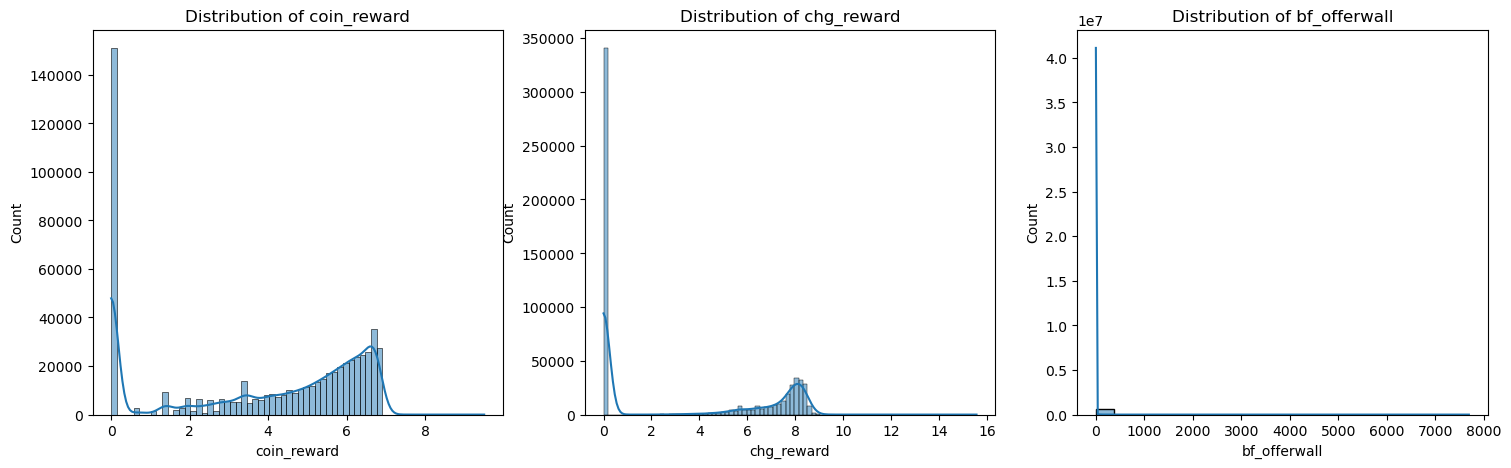

In [260]:
# 주요 콘텐츠 피쳐 확인
features = f_df[['coin_reward', 'chg_reward', 'bf_offerwall']]

# 분포 확인
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(features['coin_reward'], kde=True, ax=ax[0])
ax[0].set_title('Distribution of coin_reward')
sns.histplot(features['chg_reward'], kde=True, ax=ax[1])
ax[1].set_title('Distribution of chg_reward')
sns.histplot(features['bf_offerwall'], kde=True, ax=ax[2])
ax[2].set_title('Distribution of bf_offerwall')
plt.show()

In [268]:
tt_df.columns

Index(['Platform', 'tap_go__bf_list', 'coin_reward', 'cp_reward_bf',
       'chg_reward', 'chg_reward_cnt', 'chg_join', 'cps_reward',
       'bongtu_reward', 'invite_reward', 'cp_reward_homeCash', 'spend',
       'spend_cnt', 'avg_visit_interval', 'total_visits', 'quiz_count',
       'friend_get_link_count', 'friend_put_send_count', 'fund_receive_count',
       'launcher', 'prv_ct', 'prv_rank', 'click_cps_home_cash',
       'imp_cps_home_cash', 'imp_cpc_home_cash', 'imp_cpc_non_home_cash',
       'cp_homecoin_rev', 'click_cpc_home_cash', 'click_cpc_non_home_cash',
       'bf_offerwall'],
      dtype='object')

In [271]:
tt_df[(tt_df['chg_reward']==0) & (tt_df['coin_reward']==0)]['bf_offerwall'].sum() / tt_df[(tt_df['chg_reward']!=0) & (tt_df['coin_reward']!=0)]['bf_offerwall'].sum()

0.01185788580125695

In [275]:
len(tt_df[(tt_df['chg_reward']==0) & (tt_df['coin_reward']==0)]) / len(tt_df)

0.2404655063883934

KeyboardInterrupt: 

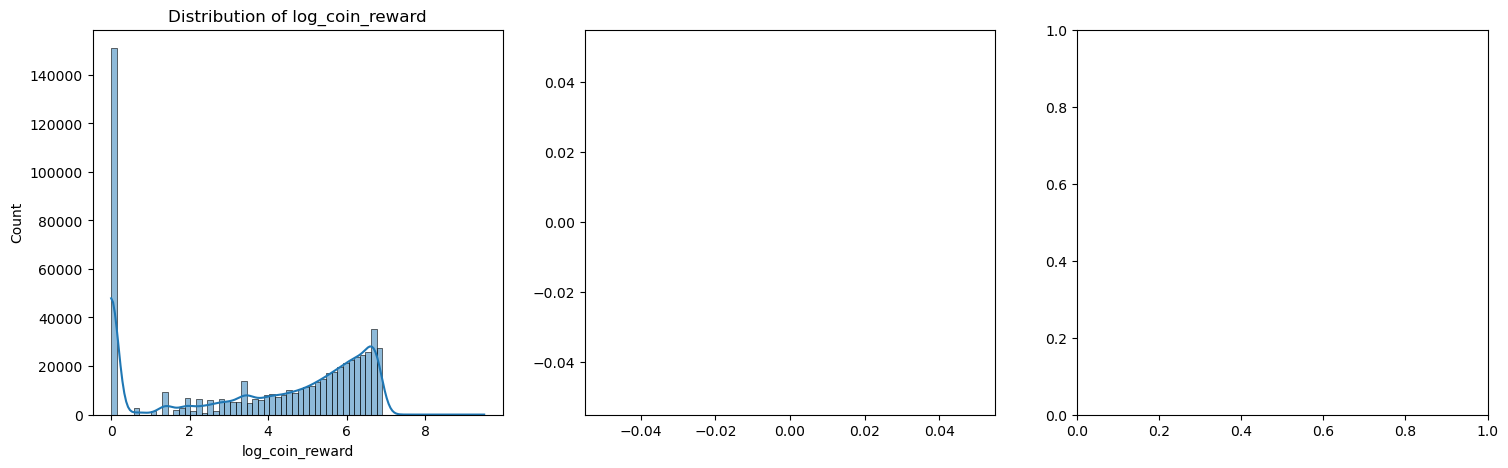

In [259]:
# 로그 변환 (0을 포함한 값을 처리하기 위해 1을 더한 후 로그 변환)
features['log_coin_reward'] = np.log1p(features['coin_reward'])
features['log_chg_reward'] = np.log1p(features['chg_reward'])
features['log_bf_offerwall'] = np.log1p(features['bf_offerwall'])

# 로그 변환 후 분포 확인
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(features['log_coin_reward'], kde=True, ax=ax[0])
ax[0].set_title('Distribution of log_coin_reward')
sns.histplot(features['log_chg_reward'], kde=True, ax=ax[1])
ax[1].set_title('Distribution of log_chg_reward')
sns.histplot(features['log_bf_offerwall'], kde=True, ax=ax[2])
ax[2].set_title('Distribution of log_bf_offerwall')
plt.show()